# Compton Edge Calibration

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import optimize
from tqdm import tqdm
import uncertainties

%matplotlib notebook

In [2]:
E1 = 1274.537 # gamma photopeak [keV]
# E1 = 511. # gamma photopeak [keV]
Ee = 511. # m_e c^2 [keV]
Emax_real = 2*E1**2/(Ee + 2*E1)
print('Emax = ',Emax_real)

k0 = 1. # constant = pi*r_e^2/(Ee*alpha^2)

alpha = E1/Ee

# compton scattering
@np.vectorize
def real_compton(T):
    s = T/E1
    if T >= Emax_real:
        return 0
    return k0*(2. + s**2./(alpha**2*(1.-s)**2) + s/(1.-s)*(s-2./alpha))

@np.vectorize
def compton(X,sigma_reso,k=1):
    def integrand(s):
        return k0*(2. + s**2./(alpha**2*(1.-s)**2) + s/(1.-s)*(s-2./alpha))*np.exp(-(X-s)**2/(2.*sigma_reso**2))
    return k*integrate.quad(integrand,0,Emax_real/E1)[0]

# gauss function
gaus = lambda p, x: p[0]/(np.sqrt(2*np.pi)*p[2])*np.exp(-(x - p[1])**2/(2*p[2]**2))
errfunc = lambda p, x, y: gaus(p,x) - y

def chi2(errfunc,p,data_x,data_y):
    chi = 0
    if len(data_x) != len(data_y):
        print('Invalid data: x and y must have the same lenght, not %d %d' %(len(data_x),len(data_y)))
        raise TypeError
    for i,x in enumerate(data_x):
        chi += errfunc(p,x,data_y[i])**2/data_y[i] # assuming poissonian error
    dof = len(data_x) - len(p)
    
    return chi,dof


# finding the proper range of data for the gaus fit
def proper_cut(X,Y):
    max_index = np.argmax(Y)
    sig_index = 0
    for i,y in enumerate(Y[max_index:]):
        if y/Y[max_index] < np.exp(-2):
            sig_index = int(i/2)
            break
    return X[max_index-sig_index:], Y[max_index-sig_index:]

def proper_cut_and_fit(X,Y,wdx=1,wsx=1,verbose=False):
    max_index = np.argmax(Y)
    sig_index = 0
    for i,y in enumerate(Y[max_index:]):
        if y/Y[max_index] < np.exp(-2):
            sig_index = int(i/2)
            break
    if verbose:
        print('Estimated mean,sigma = ',X[max_index],X[max_index + sig_index]-X[max_index])
    nX = X[np.max((0,int(max_index-wsx*sig_index))):np.min((len(X)-1,int(max_index+wdx*sig_index)))]
    nY = Y[np.max((0,int(max_index-wsx*sig_index))):np.min((len(Y)-1,int(max_index+wdx*sig_index)))]
    
    # fit
    p0 = [np.sum(nY)*(X[1]-X[0]),X[max_index],X[max_index + sig_index]-X[max_index]]
    p1, success = optimize.leastsq(errfunc,p0[:],args=(nX,nY))
    
    return nX,nY,p1

def half_maximum(X,Y):
    max_index = np.argmax(Y)
    max_y = Y[max_index]
    for i,y in enumerate(Y[max_index:]):
        if y < 0.5*max_y:
            w = X[max_index + i] - X[max_index]
            break
    return X[max_index],w
        

Emax =  1061.7027982780808


<IPython.core.display.Javascript object>


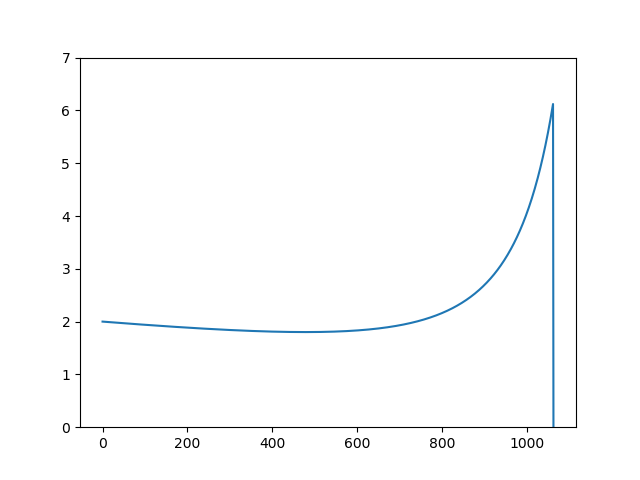

In [4]:
# real energy profile (resolution = 0)

plt.figure()
plt.ylim(0,7)
ts = np.arange(0,Emax_real+1)
rcs = real_compton(ts)

plt.plot(ts,rcs)
plt.show()

<IPython.core.display.Javascript object>


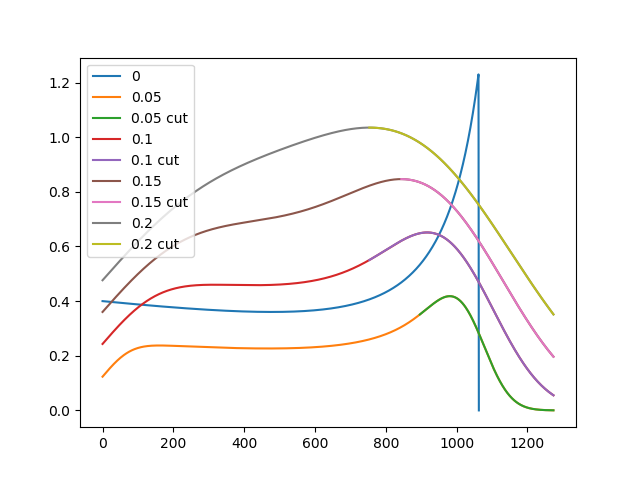

In [163]:
# energy profile with finite resolution

step = 0.001

sigmas = [0.05,0.1,0.15,0.2]
Xs = np.arange(0,1,step)

plt.figure()
ts = np.arange(0,Emax_real+1)
rcs = real_compton(ts)
plt.plot(ts,rcs/5,label='0')

for sr in sigmas:
    Cs = compton(Xs,sigma_reso=sr)
    plt.plot(Xs*E1,Cs,label=str(sr))
    nX,nC = proper_cut(Xs,Cs)
    plt.plot(nX*E1,nC,label=str(sr)+' cut')

plt.legend()
plt.show()

<IPython.core.display.Javascript object>


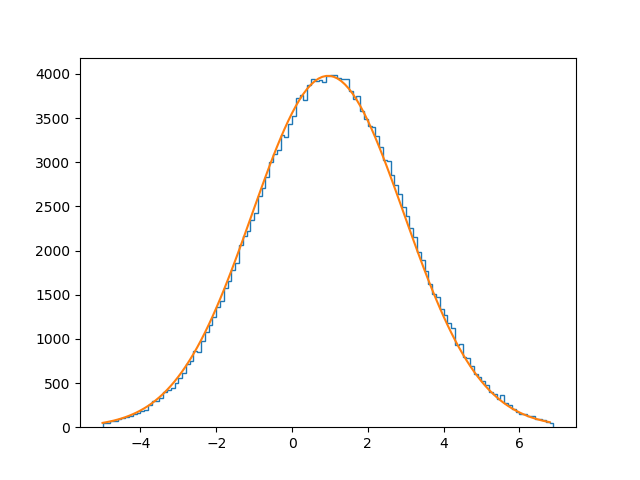

[2.00040322e+04 9.51713299e-01 2.00615109e+00] 3


(79.72951791089639, 116)

In [9]:
# testing gauss fit

p0 = [1,0,3]

ss = np.random.normal(1,2,200000)
plt.figure()
data = plt.hist(ss,bins=np.arange(-5,7,0.1),histtype='step')
plt.show()
x = data[1][:-1]
y = data[0]

p1, success = optimize.leastsq(errfunc,p0[:],args=(x,y))

plt.plot(x,gaus(p1,x))

plt.show()
print(p1,success)

chi2(errfunc,p1,x,y)

Estimated mean,sigma =  1.999999999999993 0.9999999999999787


<IPython.core.display.Javascript object>


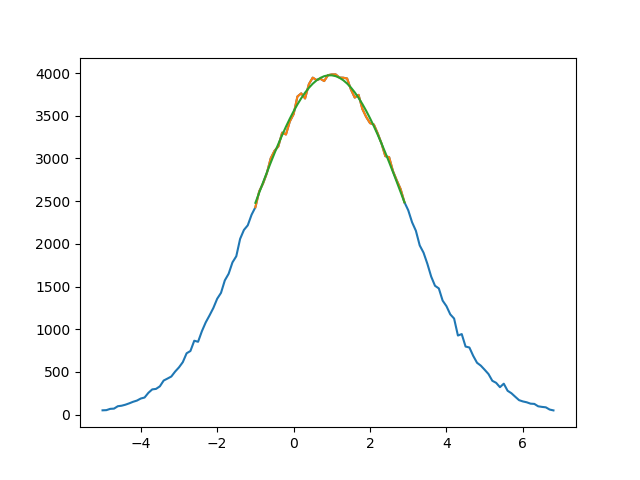

[2.00348372e+04 9.52882434e-01 2.01059018e+00]


In [25]:
newx,newy,p1 = proper_cut_and_fit(x,y,wdx=1,wsx=1)

plt.figure()
plt.plot(x,y)
plt.plot(newx,newy)
plt.plot(newx,gaus(p1,newx))
plt.show()

print(p1)

<IPython.core.display.Javascript object>


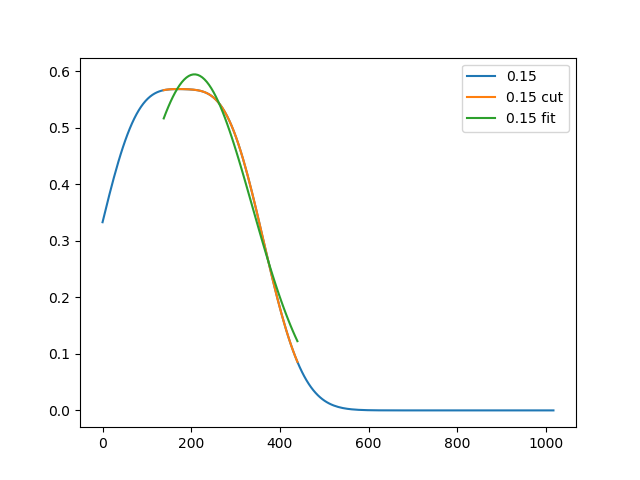

[194.80272375 207.24047141 130.64742903]


(0.11122040508996014, 57)

In [40]:
step = 0.01
sr = 0.15

Xs = np.arange(0,2,step)
Cs = compton(Xs,sigma_reso=sr)

plt.figure()
plt.plot(Xs*E1,Cs,label=str(sr))
nE,nC,p1 = proper_cut_and_fit(Xs*E1,Cs,wsx=0.2,wdx=2)
plt.plot(nE,nC,label=str(sr)+' cut')
plt.plot(nE,gaus(p1,nE),label=str(sr)+' fit')



plt.legend()
plt.show()

print(p1)
chi2(errfunc,p1,nE,nC)

In [22]:
# finding relation between sigma_reso and resolution r=sigma/centroid

step = 0.001
Xs = np.arange(0,2,step)

sr_array = np.arange(0.001,0.3,0.001)
r_array = np.zeros_like(sr_array)
peak_array = np.zeros_like(sr_array)

for i,sr in tqdm(enumerate(sr_array)):
    Cs = compton(Xs,sigma_reso=sr)
    peak, width = half_maximum(Xs*E1,Cs)
    r_array[i] = width/peak
    peak_array[i] = peak

299it [00:52,  6.51it/s]


<IPython.core.display.Javascript object>


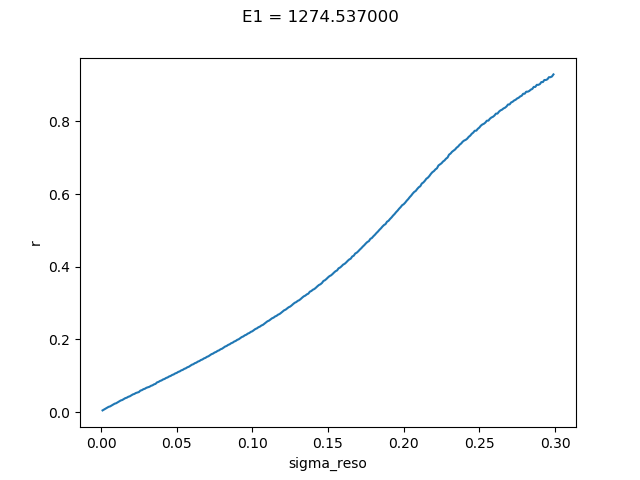

<IPython.core.display.Javascript object>


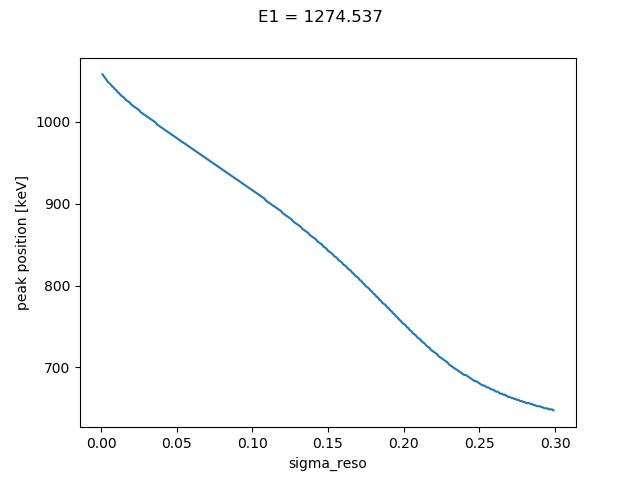

<IPython.core.display.Javascript object>


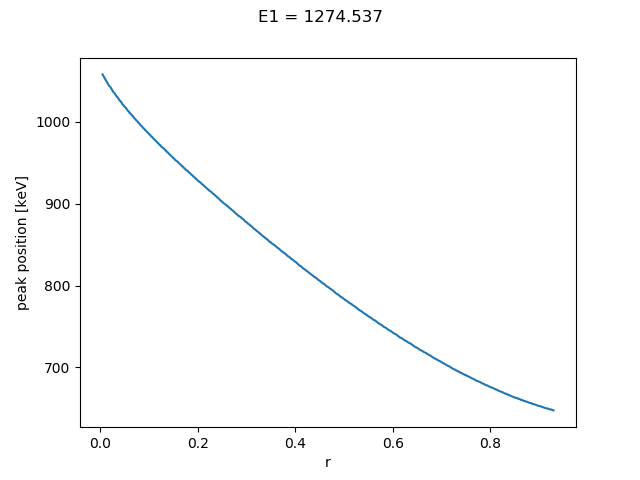

In [23]:
plt.figure()
plt.suptitle('E1 = %1f' %E1)
plt.xlabel('sigma_reso')
plt.ylabel('r')
plt.plot(sr_array,r_array)
plt.show()

plt.figure()
plt.suptitle('E1 = %.3f' %E1)
plt.xlabel('sigma_reso')
plt.ylabel('peak position [keV]')
plt.plot(sr_array,peak_array)
plt.show()

plt.figure()
plt.suptitle('E1 = %.3f' %E1)
plt.xlabel('r')
plt.ylabel('peak position [keV]')
plt.plot(r_array,peak_array)
plt.show()

<IPython.core.display.Javascript object>


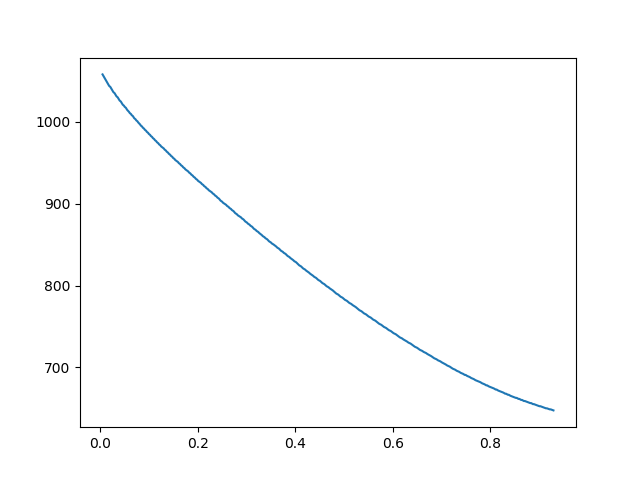

In [24]:
p_vs_r_1275 = np.stack((r_array,peak_array),axis=0)

plt.figure()
plt.plot(p_vs_r_1275[0,:],p_vs_r_1275[1,:])
plt.show()

np.save('peak_position_vs_r_1275.npy',p_vs_r_1275)

<IPython.core.display.Javascript object>


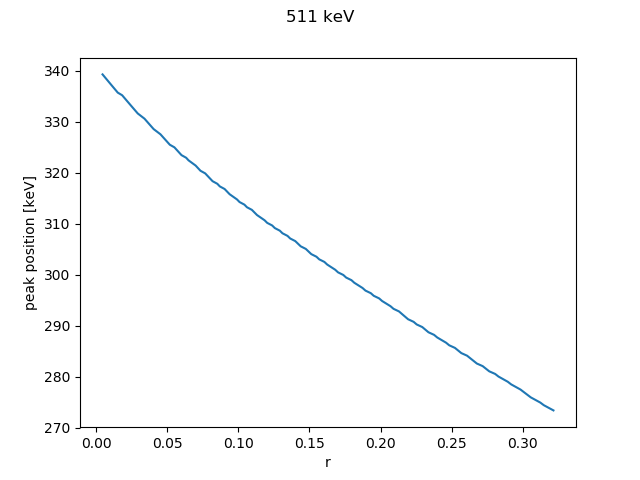

<IPython.core.display.Javascript object>


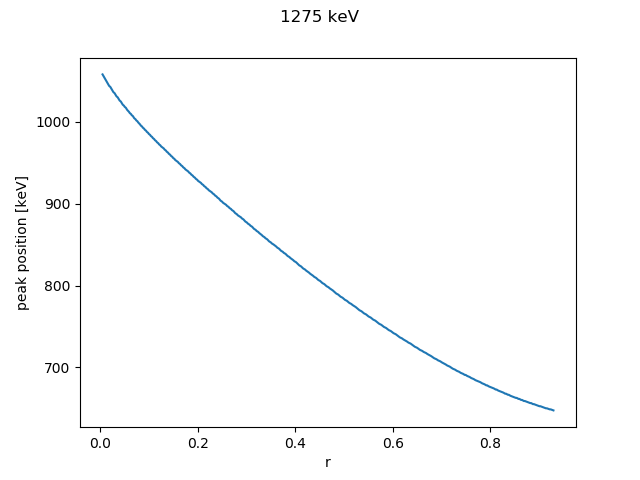

In [18]:
p_vs_r_511 = np.load('peak_position_vs_r_511.npy')

plt.figure()
plt.suptitle('511 keV')
plt.xlabel('r')
plt.ylabel('peak position [keV]')
plt.plot(p_vs_r_511[0,:],p_vs_r_511[1,:])
plt.show()

p_vs_r_1275 = np.load('peak_position_vs_r_1275.npy')

plt.figure()
plt.suptitle('1275 keV')
plt.xlabel('r')
plt.ylabel('peak position [keV]')
plt.plot(p_vs_r_1275[0,:],p_vs_r_1275[1,:])
plt.show()

## Calibration of the detectors

In [20]:
# working with uncertainties

def peak_position(E,r):
    if E == '511':
        v = p_vs_r_511
    elif E == '1275':
        v = p_vs_r_1275
    else:
        raise IndexError
    
    min_dist = 1e06
    r_v = r.nominal_value
    for i,rr in enumerate(v[0]):
        if np.abs(rr - r_v) < min_dist:
            min_dist = np.abs(rr - r_v)
            i_right = i
            
    peak_value = v[1,i_right]
    derivative = (v[1,i_right+5] - v[1,i_right])/(v[0,i_right+5] - v[0,i_right])
    peak_std_dev = r.std_dev*np.abs(derivative)
    return uncertainties.ufloat(peak_value,peak_std_dev)

def calibration_parameters(centroid_511,r_511,centroid_1275,r_1275):
    # E = a*ch + b
    E_511 = peak_position('511',r_511)
    E_1275 = peak_position('1275',r_1275)
    a = (E_1275 - E_511)/(centroid_1275-centroid_511)
    b = E_511 - (E_1275 - E_511)/(centroid_1275-centroid_511)*centroid_511
    return a,b

def getR(centroid,width,a,b):
    return width/(centroid + b/a)

def convergence(centroid_511,width_511,centroid_1275,width_1275,iterations):
    a,b = 1.,0.
    for i in range(iterations):
        r_511 = getR(centroid_511,width_511,a,b)
        r_1275 = getR(centroid_1275,width_1275,a,b)
        a,b = calibration_parameters(centroid_511,r_511,centroid_1275,r_1275)
        print(a,b)
    return a,b
    

### DET 1

In [21]:
# from root
centroid_511 = uncertainties.ufloat(3440,32/np.sqrt(12))
width_511 = uncertainties.ufloat(832,32/np.sqrt(6))
centroid_1275 = uncertainties.ufloat(11312,32/np.sqrt(12))
width_1275 = uncertainties.ufloat(960,32/np.sqrt(6))
#bin_width = 32

#getR(centroid_511,width_511,1,0)
a,b = convergence(centroid_511,width_511,centroid_1275,width_1275,iterations=5)

0.08974+/-0.00020 -21.0+/-1.6
0.09003+/-0.00020 -25.6+/-1.7
0.09010+/-0.00020 -26.3+/-1.7
0.09010+/-0.00020 -26.3+/-1.7
0.09010+/-0.00020 -26.3+/-1.7


In [22]:
print(centroid_511,width_511,centroid_1275,width_1275)

3440+/-9 832+/-13 11312+/-9 960+/-13


In [24]:
r_511 = getR(centroid_511,width_511,a,b)
E = peak_position('511',r_511)
print(r_511,E)
r_1275 = getR(centroid_1275,width_1275,a,b)
E = peak_position('1275',r_1275)
print(r_1275,E)

0.264+/-0.004 283.6+/-0.8
0.0871+/-0.0012 992.9+/-0.7


### DET 2

In [25]:
# from root
centroid_511 = uncertainties.ufloat(4400,32/np.sqrt(12))
width_511 = uncertainties.ufloat(896,32/np.sqrt(6))
centroid_1275 = uncertainties.ufloat(13392,32/np.sqrt(12))
width_1275 = uncertainties.ufloat(960,32/np.sqrt(6))
#bin_width = 32

#getR(centroid_511,width_511,1,0)
a,b = convergence(centroid_511,width_511,centroid_1275,width_1275,iterations=5)

0.07876+/-0.00015 -51.7+/-1.5
0.07927+/-0.00016 -61.1+/-1.5
0.07939+/-0.00016 -62.6+/-1.6
0.07944+/-0.00016 -63.4+/-1.6
0.07944+/-0.00016 -63.4+/-1.6


In [26]:
print(centroid_511,width_511,centroid_1275,width_1275)

4400+/-9 896+/-13 13392+/-9 960+/-13


In [27]:
r_511 = getR(centroid_511,width_511,a,b)
E = peak_position('511',r_511)
print(r_511,E)
r_1275 = getR(centroid_1275,width_1275,a,b)
E = peak_position('1275',r_1275)
print(r_1275,E)

0.249+/-0.004 286.2+/-0.7
0.0762+/-0.0010 1000.5+/-0.7
